In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
    

In [2]:
def output_corners():
    for i in range(1,21):
        inpath = "./camera_cal/calibration%d.jpg" % i
        outpath = "./output_images/corners%d.jpg" % i
        
        nx = 9
        ny = 5 if i in [1, 4, 5] else 6
        img = cv2.imread(inpath)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            cv2.imwrite(outpath, img)


In [145]:
def catalog_images():
    imgs = []
    for i in range(1, 2):
        inf = {}
        inf["path"] = "./camera_cal/calibration%d.jpg" % i
        inf["undist_path"] = "./output_images/calibration_undist%d.jpg" % i
        inf["nx"] = 9
        inf["ny"] = 5 if i == 1 else 6
        imgs.append(inf)
    return imgs

def calculate_undist():
    # make objpoints
    # find corners
    # calculate distortion
    # undistort

    imgs = catalog_images()
    objpoints = []
    imgpoints = []

    for inf in imgs:
        nx = inf["nx"]
        ny = inf["ny"]
        imgpath = inf["path"]
    
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        
        img = cv2.imread(inf["path"])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img_size = gray.shape[::-1]
        if img_size != (1280, 720):
            continue

        ret, imgp = cv2.findChessboardCorners(gray, (nx, ny), None)

        if not ret:
            continue
            
        objpoints.append(objp)
        imgpoints.append(imgp)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objp], [imgp], gray.shape[::-1], None, None)
    
    for inf in imgs:
        nx = inf["nx"]
        ny = inf["ny"]
        imgpath = inf["path"]
        img = cv2.imread(inf["path"])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        if img_size != (1280, 720):
            continue
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite(inf["undist_path"], undist)
        
    return ret, mtx, dist, rvecs, tvecs


def test_images():
    return ["./test_images/straight_lines%d.jpg" % i for i in [1, 2]] + \
           ["./test_images/test%d.jpg" % i for i in range(1,7)]
    
def trapezoid():
    res = np.float32([(457, 1400), (1190, 900), (1367, 900), (2150, 1400)])/2
    
    # made from undist_straight_lines2.jpg
    # res = np.float32([(529, 1370), (1218, 876), (1342, 876), (2120, 1370)])/2
    return res

def trapezoid_dst():
    
    res = np.float32([(457, 1400), (457, 100), (2150, 100), (2150, 1400)])/2
    
    # res = np.float32([(529, 1370), (529, 876), (2120, 876), (2120, 1370)])/2
    return res

    
def show_undist():
    ret, mtx, dist, rvecs, tvecs = calculate_undist()
    ti = test_images()
    for path in ti:
        img = cv2.imread(path)
        try:
            undist = cv2.undistort(img, mtx, dist, None, mtx)
        except:
            print(path)
            print(img)
            
        outpath = path.replace("test_images/", "output_images/undist_")
        cv2.imwrite(outpath, undist)
        
def make_perspective_transform():
    return cv2.getPerspectiveTransform(trapezoid(), trapezoid_dst())

def de_perspect(img, M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    


In [65]:
show_undist()

In [5]:
output_corners()    
    

In [12]:
trapezoid()

[[  228.5   700. ]
 [  595.    450. ]
 [  683.5   450. ]
 [ 1075.    700. ]]


True

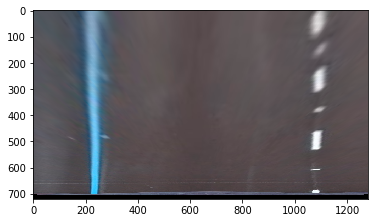

In [147]:
path = "./output_images/undist_straight_lines1.jpg"
img = cv2.imread(path)
%matplotlib inline

M = make_perspective_transform()
warped = de_perspect(img, M)

plt.imshow(warped)
cv2.imwrite(path.replace("undist", "de_perspect"), warped)
    

In [165]:
def magic_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    ch1 = hls[:,:,2]
    ch2 = img[:,:,2]
    
    magic = ch1
    magic = np.uint8(255 * magic/np.max(magic))
    return magic    

def edgify(magic):
    
    s = cv2.Sobel(magic, cv2.CV_64F, 1, 0)
    s = np.absolute(s)
    s = np.uint8(255 * s/np.max(s))
    
    res = np.zeros_like(s)
    res[(s > 30) & (s < 200)] = 255
    
    return res
   
for i in range(1,7):
    path = "./output_images/undist_test%d.jpg" % i
    img = cv2.imread(path)
    
    magic = magic_channel(img)
    cv2.imwrite(path.replace("undist", "magic"), magic)
    
    e = edgify(magic)
    cv2.imwrite(path.replace("undist", "edgy"), e)
    
    warped = de_perspect(e, M)
    cv2.imwrite(path.replace("undist", "edgy_unwarp"), warped)
    


In [156]:
np.max(e)

255

In [74]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)


In [77]:
h_channel = hsv[:,:,0]
l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]


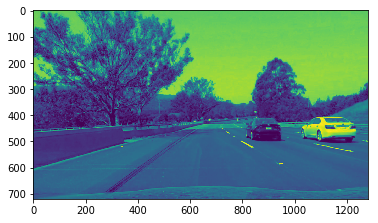

In [90]:
plt.imshow(img[:,:,0])


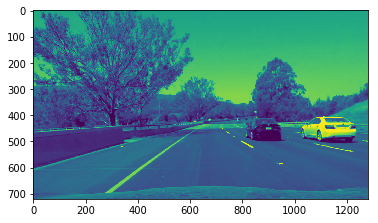

In [91]:
plt.imshow(img[:,:,1])


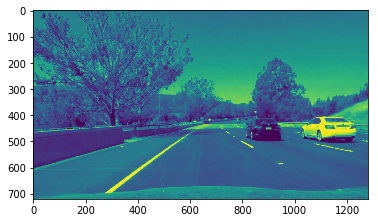

In [95]:
plt.imshow(img[:,:,2])


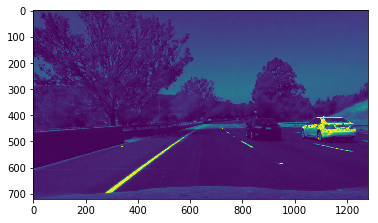

In [99]:
plt.imshow((s_channel + img[:,:,2]) * img[:,:,2])


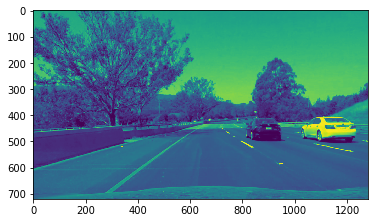

In [94]:
plt.imshow(l_channel)


In [100]:
magic = (s_channel + img[:,:,2]) * img[:,:,2]

In [101]:
magic

array([[ 23871.,  23871.,  24420., ...,  20482.,  20079.,  20079.],
       [ 23871.,  23871.,  24420., ...,  20482.,  20482.,  20482.],
       [ 24420.,  24420.,  24420., ...,  20691.,  20691.,  20691.],
       ..., 
       [ 16264.,  16416.,  16416., ...,  17515.,  17094.,  16830.],
       [ 16416.,  16416.,  16416., ...,  16416.,  16006.,  15855.],
       [ 16830.,  17094.,  17360., ...,  16006.,  16416.,  16677.]])

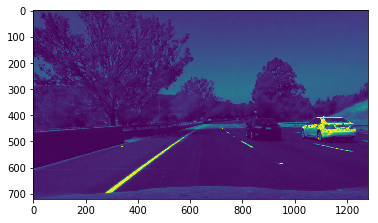

In [106]:
plt.imshow(magic)

In [103]:
np.min(magic)

0.0

In [105]:
magic = magic / np.max(magic)

In [107]:
np.max(magic)

1.0

In [108]:
magic = 255 * magic

In [109]:
sob = cv2.Sobel(magic, cv2.CV_64F, 1, 0)

In [112]:
sob = np.absolute(sob)

In [114]:
sob = np.uint8(255 * sob / np.max(sob))

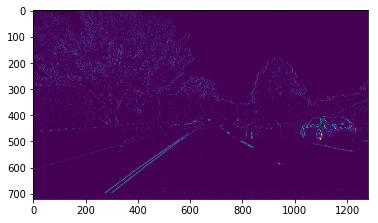

In [115]:
plt.imshow(sob)

In [116]:
sd = de_perspect(sob, M)

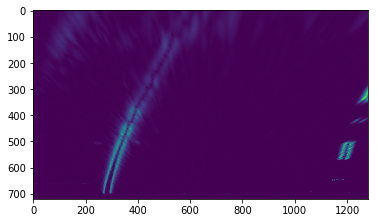

In [117]:
plt.imshow(sd)